In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

In [2]:
target = 'gaussian'

In [7]:
results = []
for trial in os.listdir('denoise/'):
    if trial.split('_')[0] == target:
        if 'from-real' in trial:
            results.append(trial)
        
results.sort()
results

['gaussian_0#0.1_None_None_from-real_0.0125_06-25-2021 15:20',
 'gaussian_0#0.1_None_None_from-real_0.05_06-25-2021 15:31',
 'gaussian_0#0.1_None_None_from-real_0.0_06-25-2021 15:26']

In [8]:
def load_trained(path):
    path = os.path.join('denoise', path)
    residual_curve = np.load(os.path.join(path, 'residual_curve.npy'))
    psnr_curve = np.load(os.path.join(path, 'psnr_curve.npy'))
    
    noise = np.load(os.path.join(path, 'noise.npy'))
    noisy = np.load(os.path.join(path, 'noisy.npy'))
    original = np.load(os.path.join(path, 'original.npy'))
    
    base_noisy = np.load(os.path.join(path, 'base_noisy.npy'))
    base_original = np.load(os.path.join(path, 'base_original.npy'))
    
    recovered_cps = [str(x) for x in Path(path).glob("**/recovered_*.npy")]
    recovered_cps.sort()
    base_cps = [str(x) for x in Path(path).glob("**/base_*.npy") if 'noisy' not in str(x) and 'original' not in str(x)]
    base_cps.sort()
    
    return noise, noisy, original, base_noisy, base_original, recovered_cps, base_cps, residual_curve, psnr_curve


def l2norm(batch_data):
    return np.sqrt((batch_data ** 2).reshape(len(batch_data), -1).sum(1))

noise_scale=0.1, gamma=0.0125, basenorm_original=[123.06523  124.384415 124.41852  125.08863 ], basenorm_noisy=[227.34059 222.70978 227.5524  226.85373]


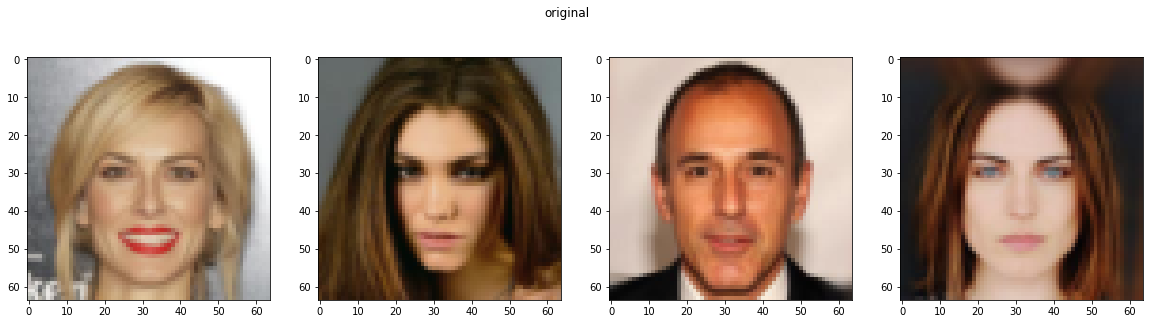

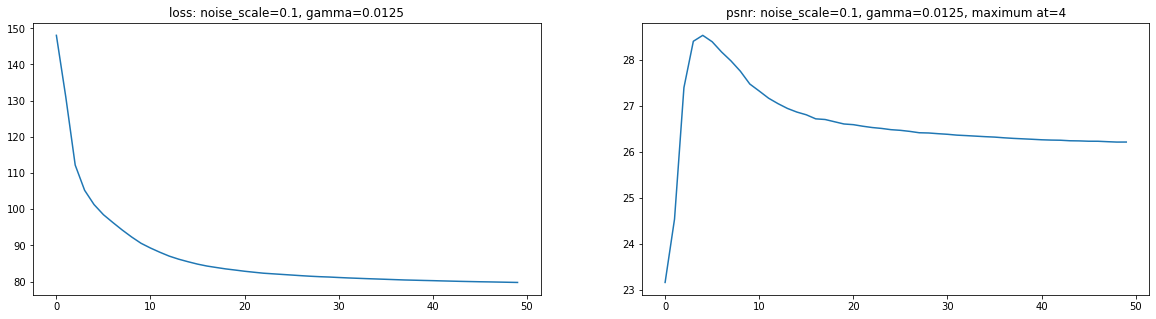

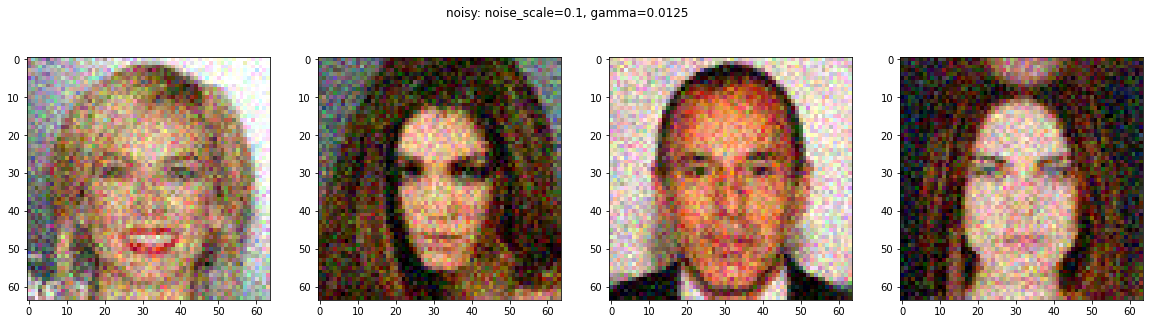

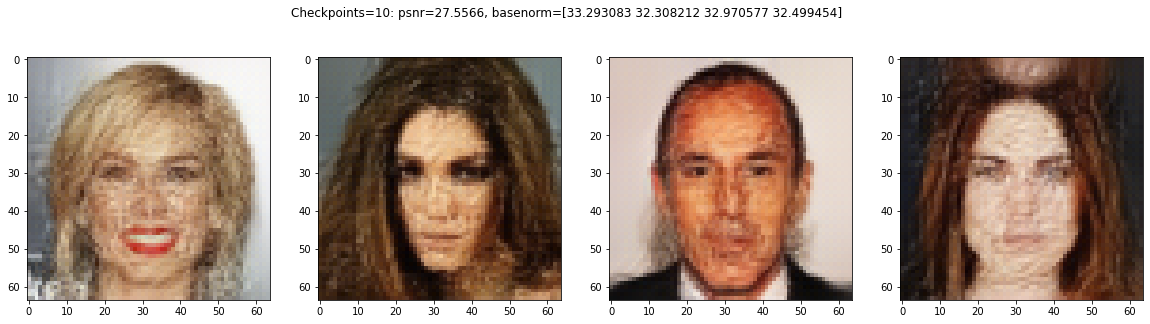

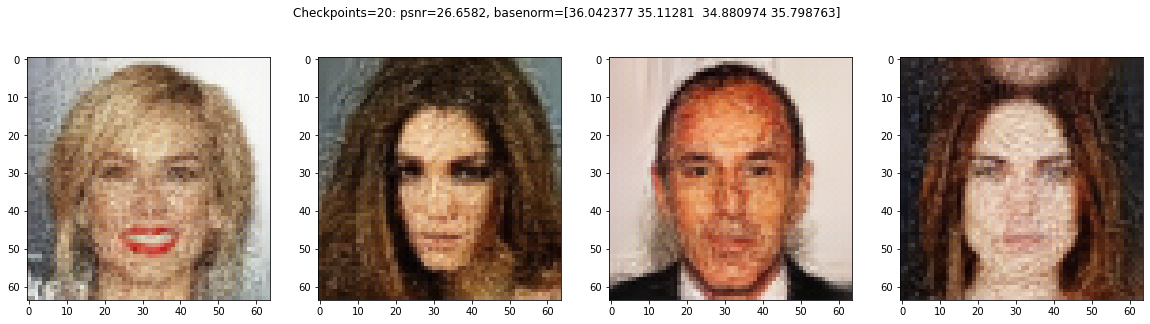

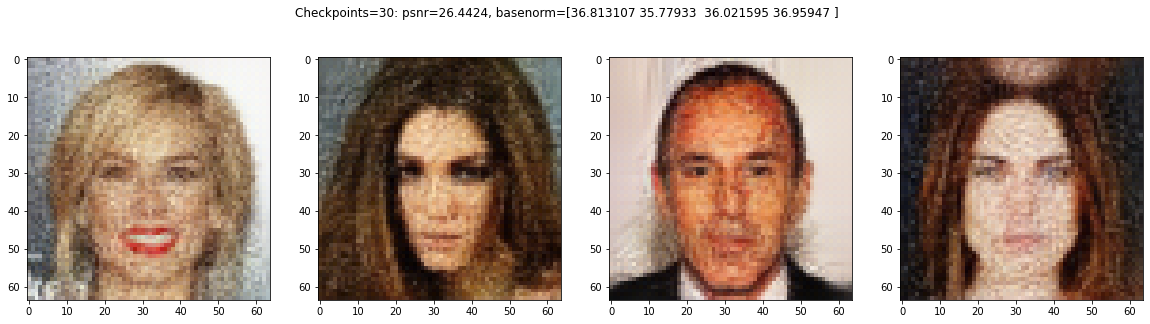

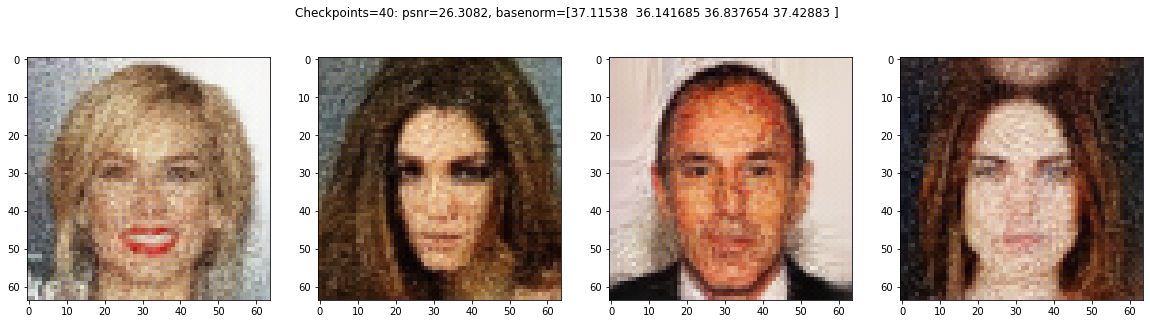

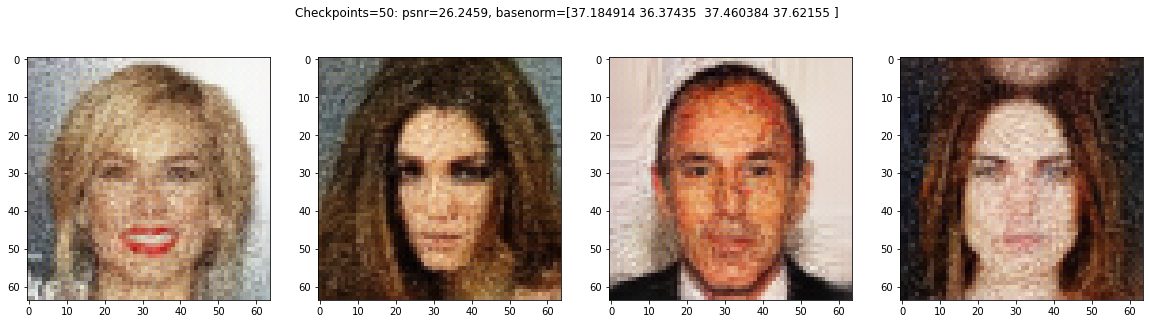





noise_scale=0.1, gamma=0.05, basenorm_original=[122.26245 123.37477 123.2232  124.7872 ], basenorm_noisy=[227.37486 223.55397 227.61703 227.29381]


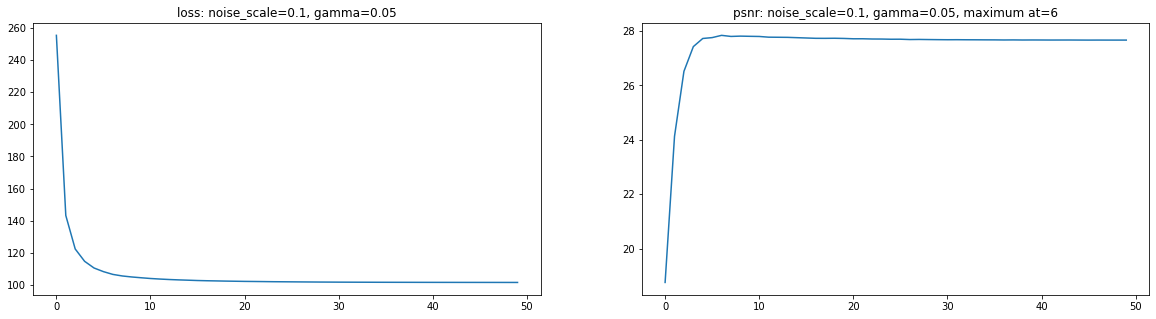

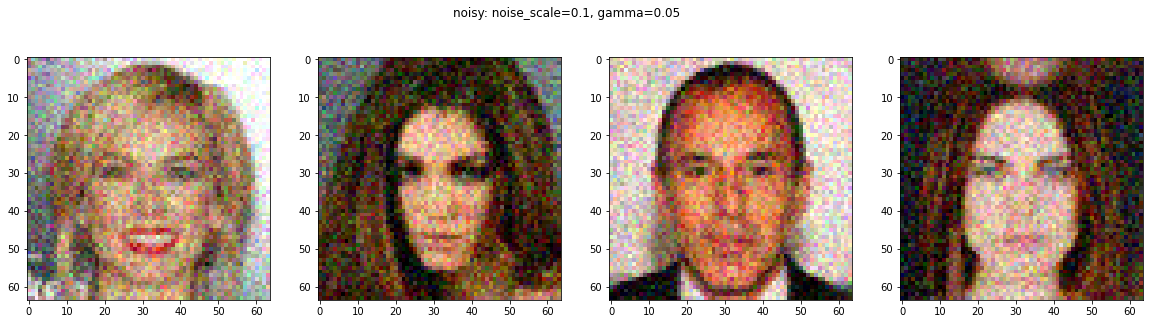

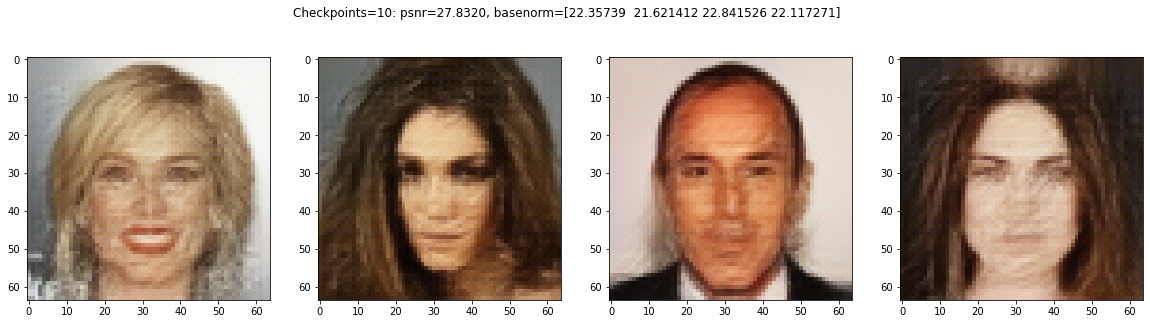

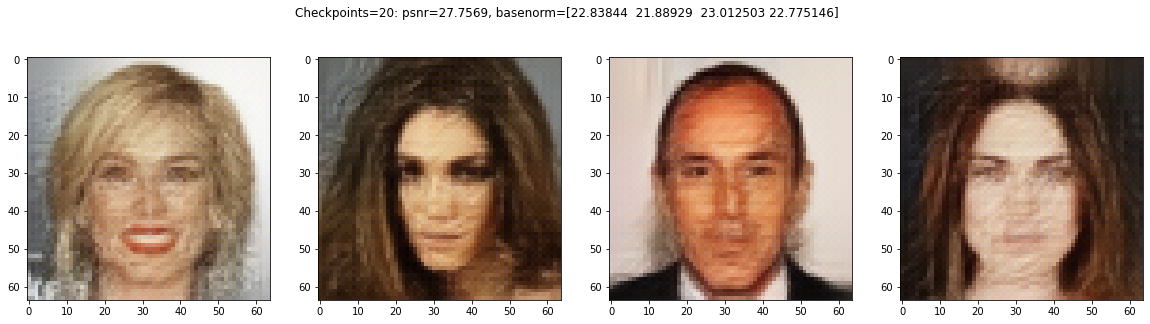

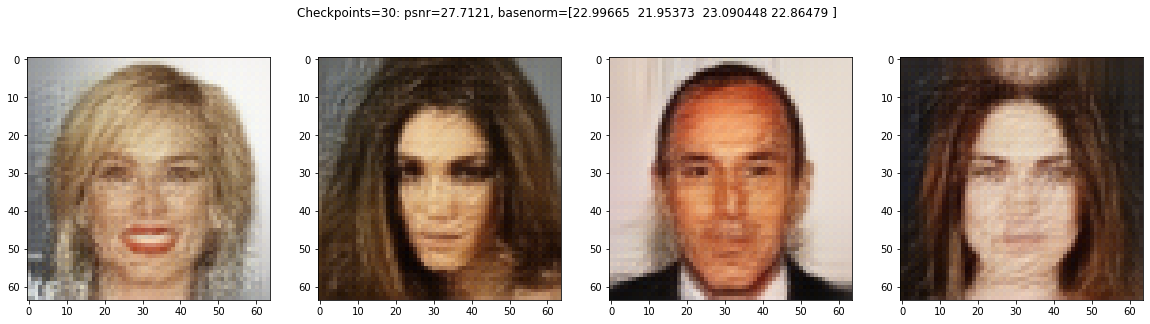

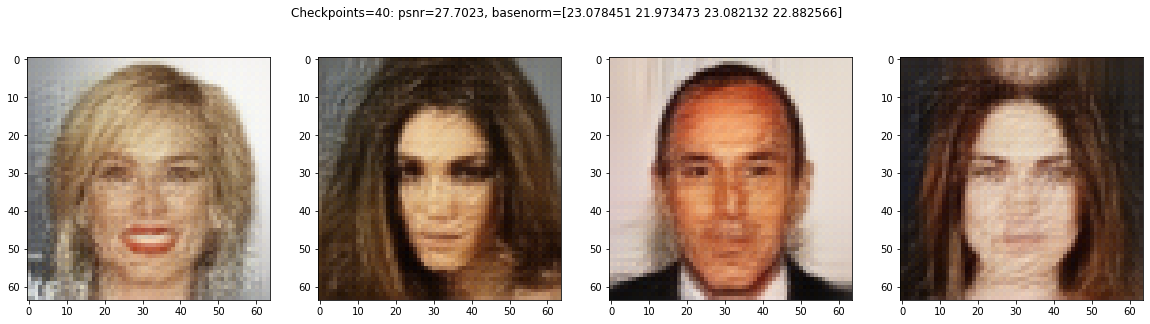

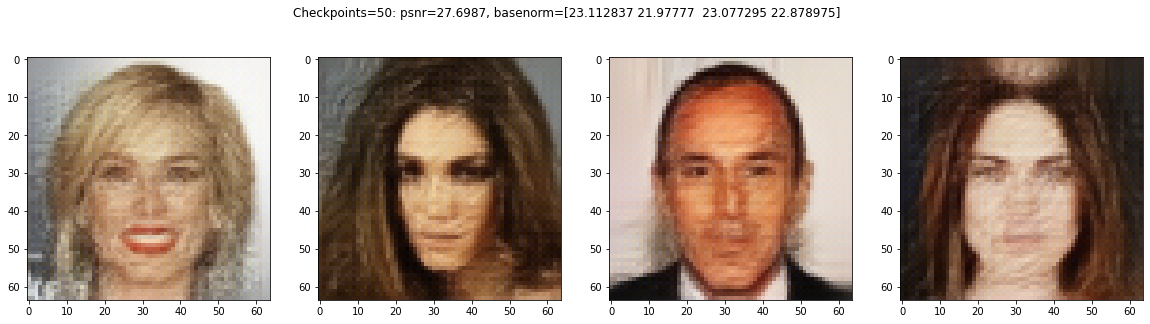





noise_scale=0.1, gamma=0.0, basenorm_original=[122.44712 123.76916 124.89963 124.39291], basenorm_noisy=[227.18333 223.1861  227.44376 226.95673]


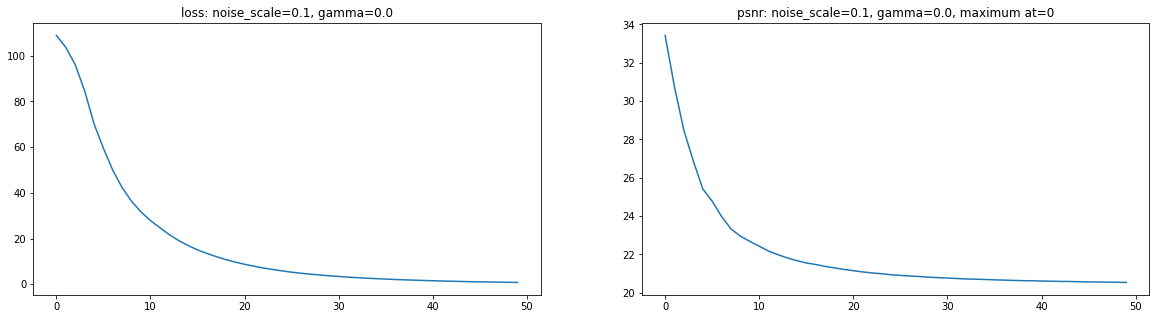

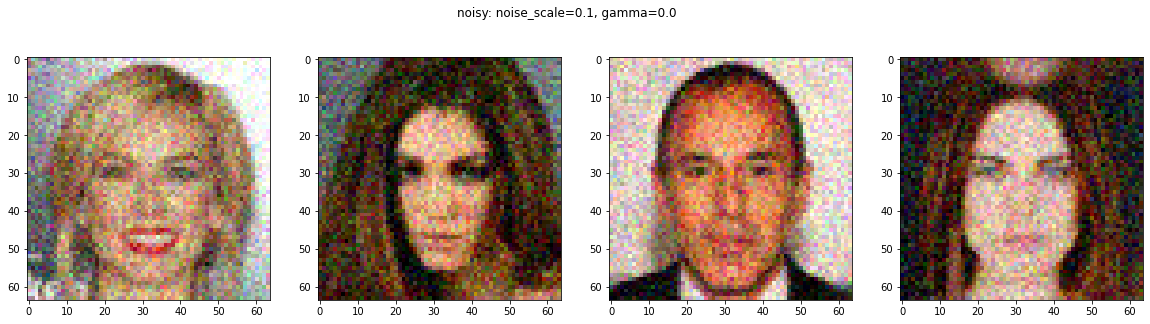

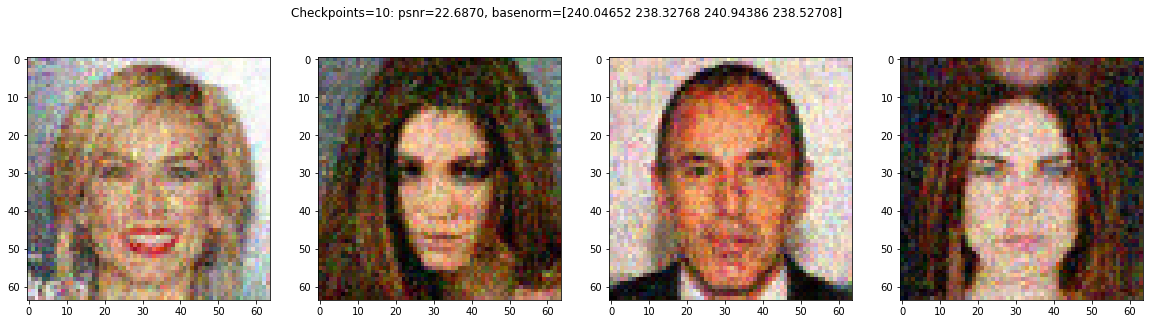

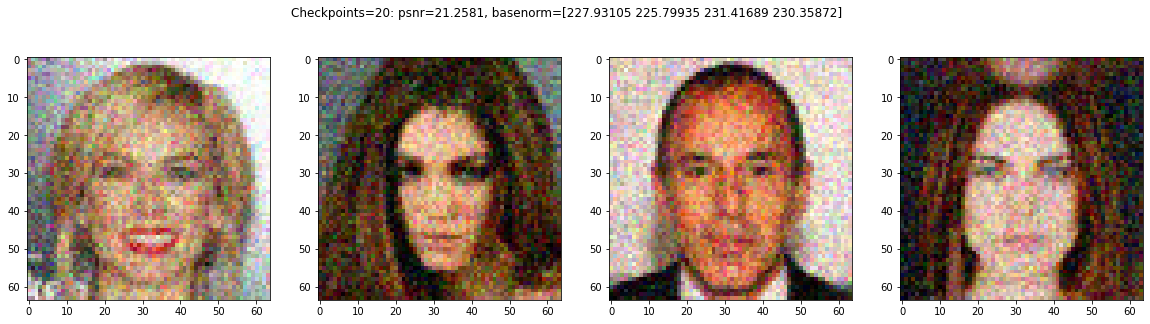

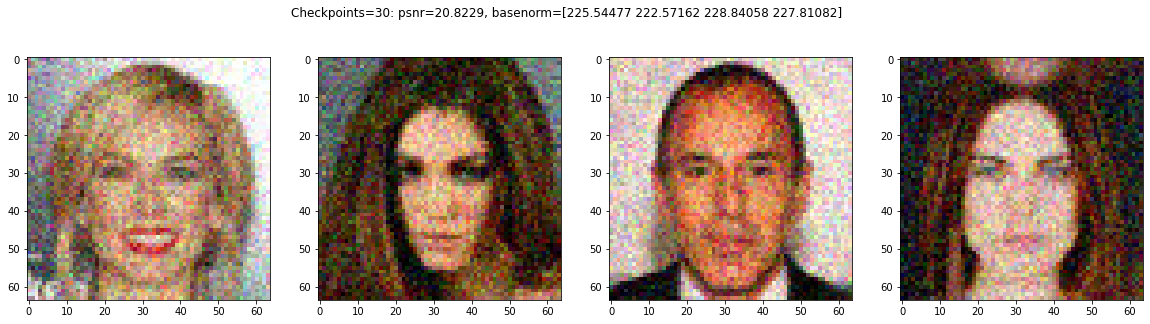

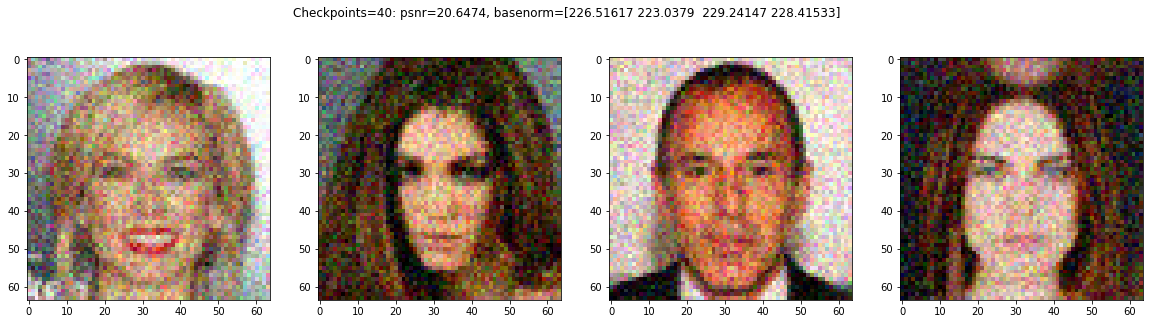

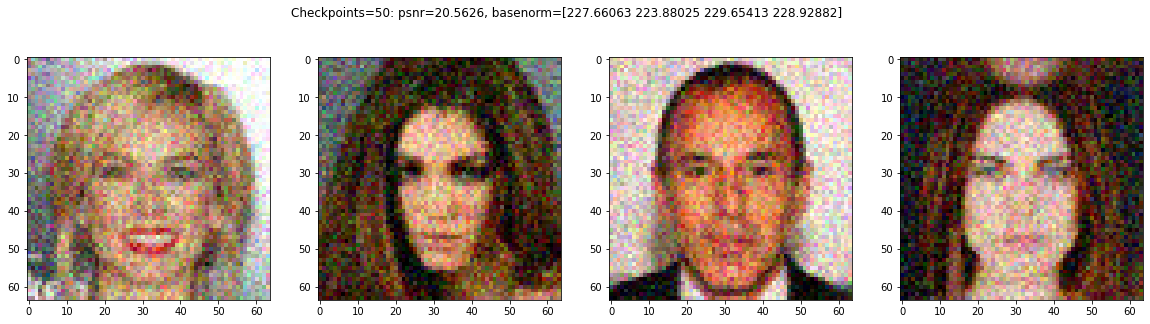

In [10]:
original_showed = False

for trial in results:
    gamma = trial.split('_')[5]
    noise_info = trial.split('_')[1]
    noise_loc, noise_scale = noise_info.split('#')
    noise, noisy, original, base_noisy, base_original, recovered_cps, base_cps, residual_curve, psnr_curve = load_trained(trial)
    print(f'noise_scale={noise_scale}, gamma={gamma}, basenorm_original={l2norm(base_original)}, basenorm_noisy={l2norm(base_noisy)}')

    if len(recovered_cps) > 0 and len(base_cps) > 0:
#         print(f'noise_scale={noise_scale}, gamma={gamma}, basenorm_original={l2norm(base_original)}, basenorm_noisy={l2norm(base_noisy)}')
        if not original_showed:
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
            for ori, ax in zip(original, axes):
                ax.imshow(ori.transpose(0, 1, 2))
            _ = plt.suptitle(f'original')
            _ = plt.show()
            original_showed = True
            
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        _ = ax1.plot(residual_curve)
        _ = ax1.set_title(f'loss: noise_scale={noise_scale}, gamma={gamma}')

        _ = ax2.plot(psnr_curve)
        _ = ax2.set_title(f'psnr: noise_scale={noise_scale}, gamma={gamma}, maximum at={np.argmax(psnr_curve)}')
        _ = plt.show()
        
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        for noisy, ax in zip(noisy, axes):
            ax.imshow(noisy.transpose(0, 1, 2))
        _ = plt.suptitle(f'noisy: noise_scale={noise_scale}, gamma={gamma}')
        _ = plt.show()
    
        recovered_cps.sort(key=lambda h: int(h.split('_')[-1].replace('.npy', '')))
        for recovered, base in zip(recovered_cps, base_cps):
            checkpoints = recovered.split('_')[-1].replace('.npy', '')
            recovered = np.load(recovered)
            base = np.load(base)
            
            psnr = [compare_psnr(x, y) for x,y in zip(original, recovered)]
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
            for recover, ax in zip(recovered, axes):
                ax.imshow(recover.transpose(0, 1, 2))
            _ = plt.suptitle(f'Checkpoints={checkpoints}: psnr={np.mean(psnr):.4f}, basenorm={l2norm(base)}')
            _ = plt.show()
    else:
        print('Failed')
    print('\n' * 3)
        
    

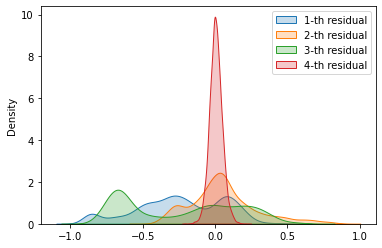

In [61]:
import seaborn as sns

for i in range(4):
    noise = (recover - original)[i].reshape(-1)
    sns.kdeplot(noise, fill=True, label=f'{i+1}-th residual')
_ = plt.legend()


97